In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from kite_trade import *
from enctoken import get_kite
kite = get_kite()
import warnings
warnings.filterwarnings(action = 'ignore')
import time
from IPython.display import clear_output
# from joblib import Parallel, delayed
# from tqdm import tqdm
# import xlwings
# import datetime
# import mibian
# import swifter
# from joblib import Parallel, delayed
# kite.ltp("NFO:NIFTY24FEB22200CE")
from nifty_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## trade

In [ ]:
config = load_config()

position_call = config["position"]["call"]
position_put = config["position"]["put"]
position_put_breakout = config["position"]["put_breakout"]
position_call_breakout = config["position"]["call_breakout"]
sl_ce_hit = config["sl_hit"]["ce"]
sl_pe_hit = config["sl_hit"]["pe"]

(strike_price_ce, strike_price_pe, symbol_ce, symbol_pe, support_ce, support_pe, resistance_ce, 
    resistance_pe, call_side, put_side, breakout, range_ce, range_pe, stop_loss_ce, stop_loss_pe, breakout_target, breakout_stop_loss,
        ) = variable_assign()

print("CE buy and target",support_ce*(1+range_ce), resistance_ce*(1-range_ce),)
print("PE  buy and target",support_pe*(1+range_pe), resistance_pe*(1-range_pe))
print("ce stop loss",support_ce*(1-stop_loss_ce))
print("pe stop loss",support_pe*(1-stop_loss_pe))

while True:
    try:
        (strike_price_ce, strike_price_pe, symbol_ce, symbol_pe, support_ce, support_pe, resistance_ce, 
         resistance_pe, call_side, put_side, breakout, range_ce, range_pe, stop_loss_ce, stop_loss_pe, breakout_target, breakout_stop_loss,
             ) = variable_assign()
        
        # Fetch current price for the call option
        price_ce = kite.ltp(symbol_ce)[symbol_ce]['last_price']
        price_pe = kite.ltp(symbol_pe)[symbol_pe]['last_price']
        print(f"CE: {price_ce}, PE: {price_pe}")
        # buy call
        if call_side:
            if ( price_ce <= support_ce*(1+range_ce) and position_call == 0 
                    and position_put == 0 and position_call_breakout == 0 and position_put_breakout == 0 and sl_ce_hit == 0):
                buy_sell_order(kite,strike_price = strike_price_ce,ce_pe = "CE", price = None,trans_type="BUY")  
                position_call = 1
                print(f"Bought call at {price_ce}","target and stop loss",resistance_ce*(1-range_ce), support_ce*(1-stop_loss_ce))

            # profit book
            if position_call == 1 and price_ce > resistance_ce*(1-range_ce):
                buy_sell_order(kite,strike_price = strike_price_ce,ce_pe = "CE", price = None,trans_type="SELL") 
                position_call = 0
                print(f"Sold call at {price_ce}")

            # stop loss
            if position_call == 1 and price_ce <= support_ce*(1-stop_loss_ce):
                buy_sell_order(kite,strike_price = strike_price_ce,ce_pe = "CE", price = None,trans_type="SELL") 
                position_call = 0
                sl_ce_hit = 1
                print(f"Sold call at {price_ce}")
                # breakout
            if breakout and sl_ce_hit ==1 and price_pe >= (resistance_pe + 3):
                buy_sell_order(kite,strike_price = strike_price_pe,ce_pe = "PE", price = None,trans_type="BUY") 
                position_put_breakout = 1
                breakout_price_pe = price_pe
                print(f"Bought put at breakout  {price_pe}","target and stop loss", breakout_price_pe*(1+breakout_target), breakout_price_pe*(1-breakout_stop_loss))


            # breakout position SL hit
            if position_put_breakout == 1 and price_pe < breakout_price_pe*(1-breakout_stop_loss):
                buy_sell_order(kite,strike_price = strike_price_pe,ce_pe = "PE", price = None,trans_type="SELL")
                break
            
            # breakout position profit book
            if position_put_breakout ==1 and price_pe > breakout_price_pe*(1+breakout_target):
                buy_sell_order(kite,strike_price = strike_price_pe,ce_pe = "PE", price = None,trans_type="SELL")
                break
                
        
        # buy put
        if put_side:
            if price_pe <= support_pe*(1+range_pe)and position_call == 0 and position_put == 0 and position_call_breakout == 0 and position_put_breakout == 0 and sl_pe_hit == 0:
                buy_sell_order(kite,strike_price = strike_price_pe,ce_pe = "PE", price = None,trans_type="BUY")  
                position_put = 1
                print(f"Bought put at {price_pe}","target and stop loss", resistance_pe*(1-range_pe), support_ce*(1-stop_loss_pe))
            
            # profit book
            if position_put == 1 and price_pe > resistance_pe*(1-range_pe):
                buy_sell_order(kite,strike_price = strike_price_pe,ce_pe = "PE", price = None,trans_type="SELL")
                position_put = 0
                print(f"Sold put at {price_pe}")

            
            # stop loss
            if position_put == 1 and price_pe <= support_pe*(1-stop_loss_pe):
                buy_sell_order(kite,strike_price = strike_price_pe,ce_pe = "PE", price = None,trans_type="SELL") 
                position_put = 0
                sl_pe_hit = 1
                print(f"Sold put at {price_pe}")
                # breakout

        if breakout and sl_pe_hit == 1 and price_ce >= (resistance_ce + 3) and position_call == 0 and position_put == 0 and position_call_breakout == 0 and position_put_breakout == 0:
            buy_sell_order(kite,strike_price = strike_price_ce,ce_pe = "CE", price = None,trans_type="BUY")
            position_call_breakout = 1
            breakout_price_ce= price_ce
            print(f"Bought CALL at breakout  {price_ce}","target and stop loss", breakout_price_ce*(1+breakout_target), breakout_price_ce*(1-breakout_stop_loss))


        # breakout position SL hit
        if position_put_breakout == 1 and price_ce < breakout_price_ce*(1-breakout_stop_loss):
            buy_sell_order(kite,strike_price = strike_price_ce,ce_pe = "CE", price = None,trans_type="SELL")
            break
        
        # breakout position profit book
        if position_put_breakout ==1 and price_ce > breakout_price_ce*(1+breakout_target):
            buy_sell_order(kite,strike_price = strike_price_ce,ce_pe = "CE", price = None,trans_type="SELL")
            break
                            
        time.sleep(5)
    except Exception as e:
        print(e)
        time.sleep(10)
            # Bought call at 141.5 target and stop loss 161.7 132.04999999999998

# backtesting 

In [ ]:
# identify the support and resistance
# filter the time 
# run the for loop with all condition 

,date,open,high,low,close,volume,oi,strike_type
0,2024-02-15 10:19:00+05:30,2405.0,2405.0,2405.0,2405.0,0.0,50.0,19500CE
1,2024-02-15 10:20:00+05:30,2405.0,2405.0,2405.0,2405.0,0.0,50.0,19500CE


In [ ]:


def buy_sell_order(strike_price, ce_pe, price, trans_type, quantity=50):
    global overall_profit_loss, trade_count, positions
    key = f"{strike_price}_{ce_pe}"
    
    if trans_type == "BUY":
        # Record the buy transaction
        trade_count += 1
        positions[key] = [price, quantity]
        # print(f"Bought {quantity} {strike_price} at {price}")
    
    elif trans_type == "SELL":
        # Calculate profit or loss from the sell transaction if the position exists
        if key in positions:
            buy_price, buy_quantity = positions[key]
            profit_loss = (price - buy_price) * min(quantity, buy_quantity)
            overall_profit_loss += profit_loss
            print(f"Sold {quantity} {ce_pe} at {price}, Profit/Loss: {profit_loss}")
            # Adjust the quantity or remove the position if completely sold
            if quantity >= buy_quantity:
                del positions[key]
            else:
                positions[key][1] -= quantity
        else:
            print("No position to sell")
    
    else:
        print("Invalid transaction type")

# Example usage:
# buy_sell_order(strike_price=100, ce_pe="CE", price=10, trans_type="BUY", quantity=10)
# buy_sell_order(strike_price=100, ce_pe="CE", price=12, trans_type="SELL", quantity=5)
# buy_sell_order(strike_price=100, ce_pe="CE", price=8, trans_type="SELL", quantity=5)



In [ ]:
df_expiry_hist_data = pd.read_parquet('../data/nifty_expiry_22feb2024_min.parquet')
df_expiry_hist_data.head(2)

sp_call =  df_expiry_hist_data.query("strike_type == '22100CE'")
sp_put =  df_expiry_hist_data.query("strike_type == '22100PE'")

positions = {}  # Keeps track of positions bought: {strike_price+ce_pe: [price, quantity]}
overall_profit_loss = 0  # Tracks overall profit or loss from all transactions
trade_count = 0

# Assuming 'kite' object is already defined and has necessary methods to fetch option prices
strike_price_ce = 22100
strike_price_pe = 22100
symbol_ce = f"NFO:NIFTY24222{strike_price_ce}CE"
symbol_pe = f"NFO:NIFTY24222{strike_price_pe}PE"

support_ce = 129
resistance_ce = 150
support_pe = 172
resistance_pe = 186

position_call  = 0 
position_put = 0 
call_side = True
put_side= True
breakout = True
position_put_breakout = 0
position_call_breakout = 0
exit_outside_loop = False

sp_call["date_only"] = pd.to_datetime(sp_call.date.dt.date)
sp_call = sp_call[sp_call.date_only == pd.to_datetime('2024-02-16')]
# filter time between 9:20 to 3:25 for date column
sp_call = sp_call[(sp_call['date'].dt.time >= pd.to_datetime('12:35').time())
                   & (sp_call['date'].dt.time <= pd.to_datetime('15:25').time())]

for r,c in sp_call.iterrows():
    # Fetch current price for the call option
   
    for price_point in ['low', 'high', 'open', 'close']:
        price_ce = c[price_point]
        price_pe = sp_put[sp_put['date'] == c['date']][price_point].values[0]

        # print(f"CE: {price_ce}, PE: {price_pe}")
        # buy call
        if call_side:
            if price_ce <= support_ce*1.03 and position_call == 0 and position_put == 0 and position_put_breakout == 0:
                buy_sell_order(strike_price = strike_price_ce,ce_pe = "CE", price = price_ce,trans_type="BUY") 
                position_call = 1
                print()
                print(c['date'],f"Bought call at {price_ce}","stop_Loss and target:", support_ce-((resistance_ce*0.97 - support_ce)/2), resistance_ce*0.97)
                print()
                break

            # profit book
            if position_call == 1 and price_ce > resistance_ce*0.97  and position_put_breakout == 0:
                buy_sell_order(strike_price = strike_price_ce,ce_pe = "CE", price = price_ce,trans_type="SELL") 
                position_call = 0
                print(f"Sold call at {price_ce}",c['date'])
                break

            # stop loss
            if position_call == 1 and price_ce <= support_ce-((resistance_ce*0.97 - support_ce)/2)  and position_put_breakout == 0:
                buy_sell_order(strike_price = strike_price_ce,ce_pe = "CE", price = price_ce,trans_type="SELL") 
                position_call = 0
                print(f"Sold call at {price_ce}",c['date'])
                print()
                # breakout
                if breakout:
                    buy_sell_order(strike_price = strike_price_pe,ce_pe = "PE", price = price_pe,trans_type="BUY") 
                    position_put_breakout = 1
                    breakout_price_pe = price_pe
                    print(f"Bought put at breakout  {price_pe}",c['date'], "stop loss and target", breakout_price_pe*.95, breakout_price_pe*1.3)
                    break
    


            # breakout position SL hit
            if position_put_breakout == 1 and price_pe < breakout_price_pe*.90:
                print("sl")
                buy_sell_order(strike_price = strike_price_pe,ce_pe = "PE", price = price_pe,trans_type="SELL")
                exit_outside_loop = True
                break
            
            # breakout position profit book
            if position_put_breakout ==1 and price_pe > breakout_price_pe*1.3:
                print('target')
                buy_sell_order(strike_price = strike_price_pe,ce_pe = "PE", price = price_pe,trans_type="SELL")
                exit_outside_loop = True
                break
    
                
        if put_side:
            if price_pe <= support_pe*1.03 and position_call == 0 and position_put == 0 and position_call_breakout == 0:
                    buy_sell_order(strike_price = strike_price_pe,ce_pe = "PE", price = price_pe,trans_type="BUY") 
                    position_put = 1
                    print()
                    print(c['date'],f"Bought put at {price_pe}","stop_Loss and target:", support_pe-((resistance_pe*0.97 - support_pe)/2), resistance_pe*0.97)
                    print()
                    break

            # profit book
            if position_put == 1 and price_pe > resistance_pe*0.97  and position_call_breakout == 0:
                buy_sell_order(strike_price = strike_price_pe,ce_pe = "PE", price = price_pe,trans_type="SELL") 
                position_put = 0
                print(f"Sold put at {price_pe}",c['date'])
                break

            # stop loss
            if position_put == 1 and price_pe <= support_pe-((resistance_pe*0.97 - support_pe)/2)  and position_call_breakout == 0:
                buy_sell_order(strike_price = strike_price_pe,ce_pe = "PE", price = price_pe,trans_type="SELL") 
                position_put = 0
                print(f"Sold put at {price_pe}",c['date'])
                print()
                # breakout
                if breakout:
                    buy_sell_order(strike_price = strike_price_ce,ce_pe = "CE", price = price_ce,trans_type="BUY") 
                    position_call_breakout = 1
                    breakout_price_ce = price_ce
                    print(f"Bought call at breakout  {price_ce}",c['date'], "stop loss and target", breakout_price_ce*.95, breakout_price_ce*1.3)
                    break



            # breakout position SL hit
            if position_call_breakout == 1 and price_ce < breakout_price_ce*.90:
                buy_sell_order(strike_price = strike_price_ce,ce_pe = "CE", price = price_ce,trans_type="SELL")
                exit_outside_loop = True
                break
            
            # breakout position profit book
            if position_call_breakout ==1 and price_ce > breakout_price_ce*1.3:
                buy_sell_order(strike_price = strike_price_ce,ce_pe = "CE", price = price_ce,trans_type="SELL")
                exit_outside_loop = True
                break
    if exit_outside_loop:
        break
        
                            
        # time.sleep(1)
print("overall profit",overall_profit_loss,trade_count)      


2024-02-16 12:35:00+05:30 Bought call at 132.3 stop_Loss and target: 120.75 145.5

Sold 50 CE at 147.0, Profit/Loss: 734.9999999999994
Sold call at 147.0 2024-02-16 12:54:00+05:30

2024-02-16 12:55:00+05:30 Bought put at 165.3 stop_Loss and target: 167.79000000000002 180.42

Sold 50 PE at 165.2, Profit/Loss: -5.000000000001137
Sold put at 165.2 2024-02-16 13:00:00+05:30

Bought call at breakout  147.0 2024-02-16 13:00:00+05:30 stop loss and target 139.65 191.1

2024-02-16 13:31:00+05:30 Bought call at 130.9 stop_Loss and target: 120.75 145.5

Sold 50 CE at 130.1, Profit/Loss: -40.00000000000057
overall profit 689.9999999999977 4


In [ ]:
xx

# pattern 

In [20]:
df_expiry_hist_data = pd.read_parquet('../data/nifty_expiry_22feb2024_5min.parquet')
df_expiry_hist_data.head(2)

sp_call =  df_expiry_hist_data.query("strike_type == '22100CE'")
sp_put =  df_expiry_hist_data.query("strike_type == '22100PE'")
sp_call["date_only"] = pd.to_datetime(sp_call.date.dt.date)
sp_call = sp_call[sp_call.date_only == pd.to_datetime('2024-02-21')]
# sp_call.rename(columns = {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace = True)

In [11]:
sp_call.head()

,date,open,high,low,close,volume,oi,strike_type,date_only
300,2024-02-21 09:15:00+05:30,184.05,187.55,163.40,170.00,1499000.0,4805450.0,22100CE,2024-02-21
301,2024-02-21 09:20:00+05:30,170.00,174.00,156.65,166.75,1024300.0,4895500.0,22100CE,2024-02-21
302,2024-02-21 09:25:00+05:30,167.45,172.15,154.00,163.25,960900.0,4941550.0,22100CE,2024-02-21
303,2024-02-21 09:30:00+05:30,162.25,165.60,151.55,163.70,887250.0,5054500.0,22100CE,2024-02-21
304,2024-02-21 09:35:00+05:30,162.75,183.15,161.85,176.60,1363650.0,5010850.0,22100CE,2024-02-21


In [21]:
import pandas as pd
import numpy as np

# Placeholder 5-minute candlestick data
data = sp_call.copy()
df = pd.DataFrame(data)

# Simplified logic to identify the pattern
# def find_pattern(df):
#     signals = []
#     for i in range(2, len(df)-1):  # Start from the 3rd row to have two previous points for comparison
#         # Check if current low is near the previous lows (within 1% of the previous lows)
#         if df['low'].iloc[i] <= df['low'].iloc[i-1]*1.01 and df['low'].iloc[i] <= df['low'].iloc[i-2]*1.01:
#             # Check for pullbacks after first and second near lows (close higher than low by at least 0.5%)
#             if df['close'].iloc[i-1] > df['low'].iloc[i-1]*1.005 and df['close'].iloc[i-2] > df['low'].iloc[i-2]*1.005:
#                 # Assuming the current point is the third low, check if there's a pullback
#                 if df['close'].iloc[i] > df['low'].iloc[i]*1.005:
#                     signals.append((df['date'].iloc[i], 'Potential Triple Bottom'))
#     return signals

# # Find and print pattern signals
# signals = find_pattern(df)
# signals


# Adjusted logic to identify the pattern with specified pullbacks between lows

# def find_refined_pattern(df):
#     signals = []
#     for i in range(4, len(df)):  # Start from the 5th row to allow space for lows and pullbacks
#         # Conditions for three sequential lows with pullbacks in between
#         if (df['low'].iloc[i] <= df['low'].iloc[i-2]*1.01 and df['close'].iloc[i-1] > df['low'].iloc[i-1]*1.005 and
#             df['low'].iloc[i-2] <= df['low'].iloc[i-4]*1.01 and df['close'].iloc[i-3] > df['low'].iloc[i-3]*1.005):
#             signals.append((df['date'].iloc[i], 'Refined Potential Triple Bottom'))
#     return signals

# # Find and print refined pattern signals
# refined_signals = find_refined_pattern(df)
# refined_signals

# Simplified Triple Bottom pattern detection in 5-minute candlestick data

# def is_downtrend(df, start_index, lookback_periods=20):
#     """Check if there's a downtrend before the start_index"""
#     if start_index < lookback_periods:
#         return False
#     trend_section = df['close'][start_index-lookback_periods:start_index]
#     return trend_section.is_monotonic_decreasing

# def find_triple_bottom(df):
#     triple_bottom_signals = []
#     resistance_levels = []
#     for i in range(50, len(df)):  # Starting from 50 to allow for downtrend and bottoms identification
#         if is_downtrend(df, i-30, 30):  # Check for downtrend before the pattern
#             for j in range(i-49, i-20):  # Look for bottoms within a window
#                 # Identify three bottoms
#                 if (abs(df['low'].iloc[j] - df['low'].iloc[j-10]) <= df['low'].iloc[j]*0.01 and
#                     abs(df['low'].iloc[j] - df['low'].iloc[j+10]) <= df['low'].iloc[j]*0.01):
#                     # Identify resistance level
#                     resistance_level = max(df['high'].iloc[j-10:j+10])
#                     resistance_levels.append((df['date'].iloc[j], resistance_level))
#                     # Check if there's a breakout through resistance after the third bottom
#                     if df['high'].iloc[i] > resistance_level:
#                         triple_bottom_signals.append((df['date'].iloc[i], 'Triple Bottom Breakout'))
#                         break  # Break after finding the first valid pattern in the window
#     return triple_bottom_signals, resistance_levels

# # Find Triple Bottom patterns
# triple_bottom_signals, resistance_levels = find_triple_bottom(data)
# triple_bottom_signals


def find_double_top(df):
    double_top_signals = []
    for i in range(20, len(df)-20):  # Starting from 20 to allow for preceding data
        # Identify first top
        if df['high'].iloc[i] > df['high'].iloc[i-1] and df['high'].iloc[i] > df['high'].iloc[i+1]:
            for j in range(i+5, i+20):  # Look for second top after at least 5 candles to allow for retracement
                # Identify second top close to the first top within a tolerance level
                if (df['high'].iloc[j] > df['high'].iloc[j-1] and 
                    df['high'].iloc[j] > df['high'].iloc[j+1] and
                    abs(df['high'].iloc[i] - df['high'].iloc[j]) <= df['high'].iloc[i]*0.02):
                    # Check for retracement to support level between the tops
                    support_level = min(df['low'].iloc[i:j])  # Minimum low between the two tops
                    if support_level < df['high'].iloc[i]*0.95:  # Example criterion for a valid support level
                        double_top_signals.append((df['date'].iloc[j], 'Double Top Potential Reversal'))
                        break  # Break to avoid detecting multiple signals in the same region
    return double_top_signals

# Find Double Top patterns
double_top_signals = find_double_top(data)
double_top_signals



[(Timestamp('2024-02-21 12:20:00+0530', tz='pytz.FixedOffset(330)'),
  'Double Top Potential Reversal'),
 (Timestamp('2024-02-21 13:40:00+0530', tz='pytz.FixedOffset(330)'),
  'Double Top Potential Reversal'),
 (Timestamp('2024-02-21 13:40:00+0530', tz='pytz.FixedOffset(330)'),
  'Double Top Potential Reversal')]

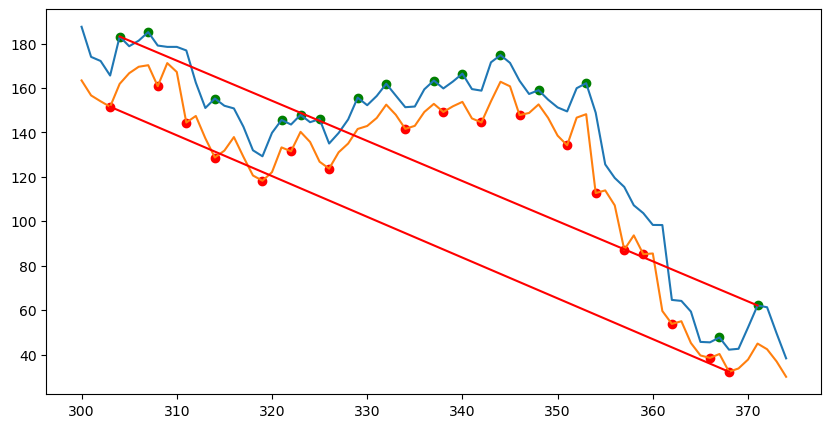

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load historical data from a CSV file
# df = pd.read_csv('path_to_your_csv.csv')
df = sp_call.copy()
# Identify significant peaks (for resistance trendline)
df['Peak'] = df['High'][(df['High'].shift(1) < df['High']) & (df['High'].shift(-1) < df['High'])]

# Identify significant troughs (for support trendline)
df['Trough'] = df['Low'][(df['Low'].shift(1) > df['Low']) & (df['Low'].shift(-1) > df['Low'])]

# Function to draw trendline between two points
def draw_trendline(ax, date1, price1, date2, price2):
    ax.plot([date1, date2], [price1, price2], 'r')

# Plot the price data
fig, ax = plt.subplots(figsize=(10,5))
df['High'].plot(ax=ax)
df['Low'].plot(ax=ax)

# Plot the peaks and troughs
ax.scatter(df.index[df['Peak'].notnull()], df['Peak'].dropna(), color='green')
ax.scatter(df.index[df['Trough'].notnull()], df['Trough'].dropna(), color='red')

# Draw trendlines (This is a simplified example, ideally you would use a more sophisticated method to choose which points to connect)
if df['Peak'].dropna().shape[0] >= 2:
    peak_dates = df.index[df['Peak'].notnull()]
    draw_trendline(ax, peak_dates[0], df['Peak'].dropna().iloc[0], peak_dates[-1], df['Peak'].dropna().iloc[-1])

if df['Trough'].dropna().shape[0] >= 2:
    trough_dates = df.index[df['Trough'].notnull()]
    draw_trendline(ax, trough_dates[0], df['Trough'].dropna().iloc[0], trough_dates[-1], df['Trough'].dropna().iloc[-1])

# Show the plot
plt.show()


In [29]:
sp_call.to_csv("sp_call.csv",index = False)

In [5]:
import plotly.graph_objects as go
import pandas as pd

# Assuming 'data' is your DataFrame with columns: 'date', 'Open', 'High', 'Low', 'Close'
# Make sure your 'date' column is in datetime format
data = sp_call.copy()
data['date'] = pd.to_datetime(data['date'])

# Create a candlestick chart
fig = go.Figure(data=[go.Candlestick(x=data['date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

# Update the layout for a more comprehensive view
fig.update_layout(title='Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible=False)  # Hide the range slider for a cleaner look

# Show the figure
fig.show()


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
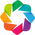

:Overlay
   .Segments.I    :Segments   [x0,y0,x1,y1]
   .Rectangles.I  :Rectangles   [x0,y0,x1,y1]
   .Rectangles.II :Rectangles   [x0,y0,x1,y1]

In [7]:
import holoviews as hv
import pandas as pd
from holoviews import opts, dim

# Ensure HoloViews is loaded with the Bokeh backend
hv.extension('bokeh')

# Assuming 'data' is your DataFrame and has been loaded correctly
data['date'] = pd.to_datetime(data['date'])

# Define segments for the high-low prices
segments = hv.Segments((data['date'], data['Low'], data['date'], data['High'])).opts(
    line_width=1, color='black')

# Define rectangles for the open-close prices
# The width of the rectangles is arbitrary and may need adjustment
width = 0.8

# Positive changes (close > open)
pos_bars = hv.Rectangles((data.loc[data['Close'] > data['Open'], 'date'] - pd.Timedelta(minutes=width/2),
                           data.loc[data['Close'] > data['Open'], 'Open'],
                           data.loc[data['Close'] > data['Open'], 'date'] + pd.Timedelta(minutes=width/2),
                           data.loc[data['Close'] > data['Open'], 'Close'])).opts(fill_color='green')

# Negative changes (close < open)
neg_bars = hv.Rectangles((data.loc[data['Close'] < data['Open'], 'date'] - pd.Timedelta(minutes=width/2),
                           data.loc[data['Close'] < data['Open'], 'Close'],
                           data.loc[data['Close'] < data['Open'], 'date'] + pd.Timedelta(minutes=width/2),
                           data.loc[data['Close'] < data['Open'], 'Open'])).opts(fill_color='red')

# Overlay the plots
candlestick_chart = (segments * pos_bars * neg_bars).opts(
    opts.Rectangles(line_color='black'),
    opts.Segments(toolbar='above', width=800, height=400, xaxis=None),
    opts.Overlay(show_legend=False)).opts(
    xaxis='bottom')

# Display the plot
candlestick_chart


In [27]:
import pandas as pd
import hvplot.pandas  # adds hvplot method to pandas objects

# Load historical data from a CSV file
# df = pd.read_csv('path_to_your_csv.csv', parse_dates=['date'])
df = sp_call.copy()
df = df.sort_values('date')

# Assume that df has columns 'date', 'High', 'Low'

# Identify significant peaks for resistance trendlines
df['Peak'] = df['High'][(df['High'].shift(1) < df['High']) & (df['High'].shift(-1) < df['High'])]

# Identify significant troughs for support trendlines
df['Trough'] = df['Low'][(df['Low'].shift(1) > df['Low']) & (df['Low'].shift(-1) > df['Low'])]

# Plot the High and Low prices using hvplot
plot = df.hvplot(x='date', y=['High', 'Low'], width=800, height=400)

# Overlay scatter plots for Peaks and Troughs using hvplot.scatter
plot *= df.dropna(subset=['Peak']).hvplot.scatter(x='date', y='Peak', color='green', marker='^', size=100)
plot *= df.dropna(subset=['Trough']).hvplot.scatter(x='date', y='Trough', color='red', marker='v', size=100)

# Draw trendlines for Peaks and Troughs using the hvplot.line method
peaks = df.dropna(subset=['Peak'])
if len(peaks) > 1:
    plot *= peaks.hvplot.line(x='date', y='Peak', color='green')

troughs = df.dropna(subset=['Trough'])
if len(troughs) > 1:
    plot *= troughs.hvplot.line(x='date', y='Trough', color='red')

plot

:Overlay
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Scatter.I   :Scatter   [date]   (Peak)
   .Scatter.II  :Scatter   [date]   (Trough)
   .Curve.I     :Curve   [date]   (Peak)
   .Curve.II    :Curve   [date]   (Trough)

In [ ]:
# # Assuming 'kite' object is already defined and has necessary methods to fetch option prices
# strike_price = 21950
# symbol_ce = f"NFO:NIFTY24222{strike_price}CE"
# symbol_pe = f"NFO:NIFTY24222{strike_price}PE"
# support = 25
# resistance = 41

# position_call  = 0 
# position_put = 0 
# price = None  # Placeholder for the option premium price

# while True:
#     # Fetch current price for the call option
#     price_ce = kite.ltp(symbol_ce)[symbol_ce]['last_price']
#     price_pe = kite.ltp(symbol_pe)[symbol_pe]['last_price']
#     print(f"CE: {price_ce}, PE: {price_pe}")

#     break
#     # Buy call if price reached near support and no position is open
#     if price_ce <= support*.99 and price_ce >= support*1.01 and position_call == 0 and position_put == 0:
#         buy_sell_order(strike_price = strike_price,ce_pe = "CE", price = None,trans_type="BUY")  
#         position_call = 1
#         print(f"Bought call at {price_ce}")
    
#     # Sell call if price reached near resistance and call position is open
#     elif price_ce >= resistance and position_call == 1:
#         buy_sell_order(strike_price = strike_price,ce_pe = "CE", price = None,trans_type="SELL") 
#         position_call = 0
#         print(f"Sold call at {price_ce}")
    
#     # Sell call and buy put if call position is open and price goes below support by 10%
#     elif position_call == 1 and price_ce < (support * 0.90):
#         buy_sell_order(strike_price = strike_price,ce_pe = "CE", price = None,trans_type="SELL") 
#         time.sleep(5)
#         buy_sell_order(strike_price = strike_price,ce_pe = "PE", price = None, trans_type="BUY")
#         position_call = 0  
#         position_put = 1
#         print(f"Switched to put at {price_pe}")
    
#     # Buy call if price crosses the resistance by 5 points and no position is open
#     elif price_ce > (resistance + 5) and position_call == 0:
#         buy_sell_order(strike_price = strike_price,ce_pe = "CE", price = None,trans_type="BUY") 
#         position_call = 1
#         print(f"Bought call at {price_ce}")
    
#     # time.sleep(5)  # Adjust the sleep time as needed
#     # clear_output(wait=True)
#     break

CE: 35.3, PE: 34.05


In [ ]:
inst = pd.DataFrame(kite.instruments("NFO"))
inst_nse = pd.DataFrame(kite.instruments("NSE"))

In [ ]:
expiry_sp = 'NIFTY24222'
inst = pd.DataFrame(kite.instruments("NFO"))

expiry_march  = inst[(inst.name == 'NIFTY') & (inst.tradingsymbol.str.contains(expiry_sp))]
# expiry_march = expiry_march.query("(strike >= 38500 )&( strike <= 40500)")
# expiry_march['strike_type'] = expiry_march['strike'].astype(int).astype(str) + expiry_march['instrument_type']

In [ ]:
expiry_march

,instrument_token,exchange_token,tradingsymbol,name,last_price,expiry,strike,tick_size,lot_size,instrument_type,segment,exchange
773,9091074,35512,NIFTY2422219500CE,NIFTY,0.0,2024-02-22,19500.0,0.05,50,CE,NFO-OPT,NFO
774,9091330,35513,NIFTY2422219500PE,NIFTY,0.0,2024-02-22,19500.0,0.05,50,PE,NFO-OPT,NFO
775,9092098,35516,NIFTY2422219550CE,NIFTY,0.0,2024-02-22,19550.0,0.05,50,CE,NFO-OPT,NFO
776,9092354,35517,NIFTY2422219550PE,NIFTY,0.0,2024-02-22,19550.0,0.05,50,PE,NFO-OPT,NFO
777,9093634,35522,NIFTY2422219600CE,NIFTY,0.0,2024-02-22,19600.0,0.05,50,CE,NFO-OPT,NFO
...,...,...,...,...,...,...,...,...,...,...,...,...
948,10363906,40484,NIFTY2422223850PE,NIFTY,0.0,2024-02-22,23850.0,0.05,50,PE,NFO-OPT,NFO
949,15559170,60778,NIFTY2422223900CE,NIFTY,0.0,2024-02-22,23900.0,0.05,50,CE,NFO-OPT,NFO
950,15560194,60782,NIFTY2422223900PE,NIFTY,0.0,2024-02-22,23900.0,0.05,50,PE,NFO-OPT,NFO
951,15560450,60783,NIFTY2422223950CE,NIFTY,0.0,2024-02-22,23950.0,0.05,50,CE,NFO-OPT,NFO


In [ ]:
# nifty_token = 256265 # NIFTY 50	
# expiry_day = 'NIFTY24215'

# expiry_march = (
#     inst[(inst.name == "NIFTY") & (inst.tradingsymbol.str.contains(expiry_day))]
#     # .query("(strike >= @lower_price )&( strike <= @upper_price)")
#     # .assign(strike_type=lambda x: x["strike"].astype(int).astype(str) + x["instrument_type"])
# )
# df = pd.DataFrame(kite.historical_data(nifty_token, from_date = start_dt, to_date = end_dt, interval = time_frame, continuous=False, oi=True))

In [ ]:
kite.ltp

In [ ]:
# price consolidation i
from IPython.display import clear_output
import time
strike_price = 42900
position = 0
market  = False

lower_side = 42811
upper_side = 42911

target_lower = 49000
target_upper = 42488

sl_lower = 42228
sl_upper = 42299


if market:
    order_type  = kite.ORDER_TYPE_MARKET
else:
    order_type  = kite.ORDER_TYPE_LIMIT

symbol_ce = f"NFO:BANKNIFTY23504{strike_price}CE"
symbol_pe = f"NFO:BANKNIFTY23504{strike_price}PE"
# price = 385
while(True):
    bn_index = kite.ltp('NSE:NIFTY BANK')['NSE:NIFTY BANK']['last_price']
    op_begin_ce = kite.ltp(symbol_ce)[symbol_ce]['last_price']
    op_begin_pe = kite.ltp(symbol_pe)[symbol_pe]['last_price']
    print(bn_index,op_begin_ce,op_begin_pe)
    # buy 
    if bn_index > upper_side and position == 0:
        print('buy_up', bn_index) 
        trans_type = kite.TRANSACTION_TYPE_BUY
        op_begin_ce -= 5
        buy_sell_order(strike_price = strike_price,price =op_begin_ce, ce_pe = 'CE', trans_type = trans_type,order_type =order_type)
        position = 1 
        
    elif bn_index < lower_side and position == 0:
        print("buy_down",bn_index)
        trans_type = kite.TRANSACTION_TYPE_BUY
        op_begin_pe -= 5
        buy_sell_order(strike_price = strike_price,ce_pe = 'PE', trans_type = trans_type,order_type = order_type)
        position = 1
    
    # if position == 1 and (bn_index > target_upper or bn_index < sl_upper): 
    #     trans_type = kite.TRANSACTION_TYPE_SELL
    #     order_type  = kite.ORDER_TYPE_MARKET
    #     buy_sell_order(strike_price = strike_price,ce_pe = 'CE',price = None, trans_type = trans_type,order_type = order_type)
    #     break
    # elif position == 1 and (bn_index < target_lower or bn_index > sl_lower):
    #     trans_type = kite.TRANSACTION_TYPE_SELL
    #     buy_sell_order(strike_price = strike_price,ce_pe = 'PE',price = None, trans_type = trans_type,order_type = order_type)
    #     break
        
    time.sleep(5)
    clear_output(wait=True)
    # break

    